## Shifted log-scale
In this notebook we perform the estimation with parameters on a shifted log-scale $\log_{10}(\epsilon+x)$, where $\epsilon$ is the shift parameter.

In [54]:
import os
import importlib
import pandas as pd

import amici
import matplotlib.pyplot as plt
import numpy as np 
import petab 

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

### Model import
Since there is no build-in version for parameters on the shifted scale, we import the petab model with parameters specified to be linear and then later transform them by hand. The only thing that changes in this petab model is the nominal value of the parameters, which is the transform of the nominal value in the linear model.

In [ ]:
model_name= "Spoegler_conversionReaction"
param_scale= "log10_shift"


# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# or create from folder (did not work)
# petab_problem = petab.Problem.from_folder("petab/"+param_scale)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model()

# model properties
print("Model parameters:", list(model.getParameterIds()), "\n")
print("Model constant parameters:", list(model.getFixedParameterIds()), "\n")
print("Model outputs:    ", list(model.getObservableIds()), "\n")
print("Model states:     ", list(model.getStateIds()), "\n")

In [57]:
# initialize solver and options
solver = importer.create_solver(model)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model.requireSensitivitiesForAllParameters()                   

### Create objective function
In the next part we first create an objective function out of the model. This function takes parameters as if they were on a linear scale, since we specified it this way in the PEtab problem.
In order to get an objective function that can take parameters on the shifted scale, we concatenate the linear objective function with the inverse of the parameter transformation.
And for the gradient we use: $(f'(x))^{-1}=\frac{1}{f'(x)}$ for bijective functions.
So with the input being: $x=f(y)=log_{10}(\epsilon+y)$
We get $obj(x)=obj.lin(f^{-1}(x))$ as the new objective function and $obj'(x)=obj.lin'(f^{-1}(x))*10^x*ln(10)$ as the new derivative.

In [58]:
# linear objective function
obj_lin = importer.create_objective()

# shifted parameter
eps = 1
def fun(x):
    return obj_lin.get_fval(10**np.array(x)-eps)

def grad(x):
    return obj_lin.get_grad(10**np.array(x)-eps) * 10**np.array(x) * np.log(10)


# new objective function
obj = pypesto.Objective(fun=fun, grad=grad)

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/amici_models/Sp_gler_ConversionReaction.


In [59]:
obj_lin([0.2, 0.1, 0.0, 0.15])

-3.418410576784529

So the obj_lin is different from the objective function in the linear-scale case. This is suspicious and should normally not be the case.

In [68]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', obj(petab_problem.x_nominal))



optimal x =  [0.07918125, 0.04139269, 0.0, 0.17609126]
optimal lh value 1.5753096950853929


Look at this later!

In [ ]:
# check gradient
# test_opt = obj.check_grad(petab_problem.x_nominal)
# print(test_opt[np.array(['grad', 'fd_c', 'abs_err', 'rel_err'])])
# test_1 = obj.check_grad([1,1,1,1])
# print(test_1[np.array(['grad', 'fd_c', 'abs_err', 'rel_err'])])

In [61]:
# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem = importer.create_problem(obj)

# do the optimization
n_starts = 100

result = optimize.minimize(
        problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None
)

 70%|███████   | 70/100 [00:48<00:33,  1.13s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 59.1655, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 59.165495:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value for fxdot[0]!
[Warning] AMICI:NaN: AMICI encountered a NaN value for p[0]!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value for fxdot[0]!
[Warning] AMICI:NaN: AMICI encountered a NaN value for p[0]!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:s

In [62]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', problem.objective(best_result))


best parameter:  [0.11199532 0.02406101 0.00076236 0.03855329]
best likelihood value:  -5.748130204519293


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

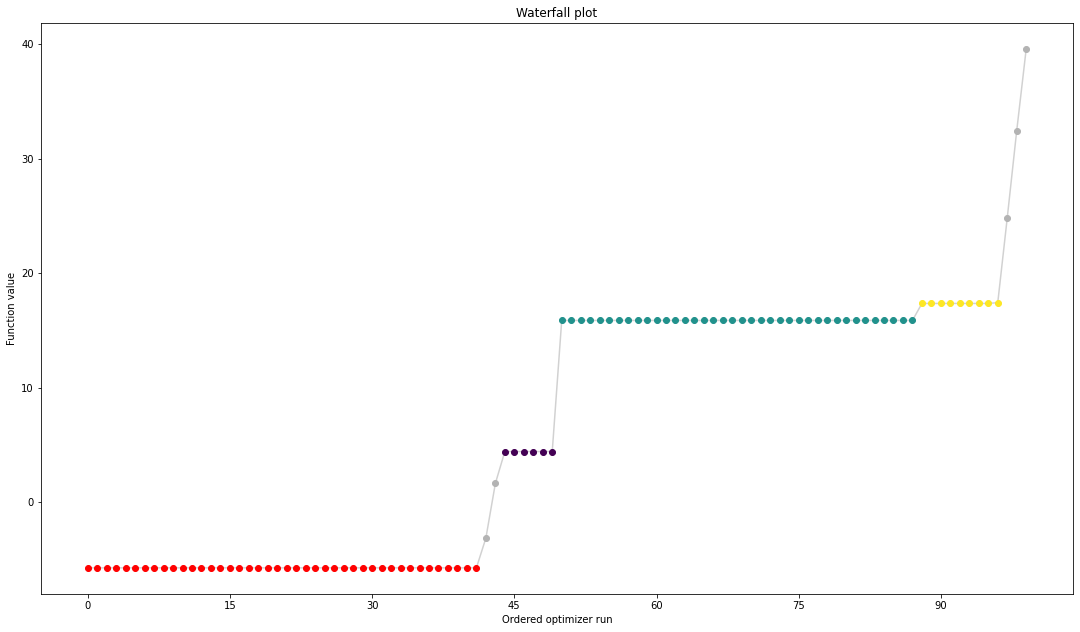

In [64]:
# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

In [65]:
# converged means close to the best result up to a threshold

threshold = 1e-2
n_compares = len(result.optimize_result.as_list("x"))
n_converged = 0
for i in range(0, n_compares):
    compare_result = result.optimize_result.as_list("x")[i]["x"]
    converged = (np.abs((compare_result - best_result)) < (threshold * len(compare_result))).all()
    if converged:
        n_converged += 1

print("Number of converged runs: ", n_converged) 

Number of converged runs:  43


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

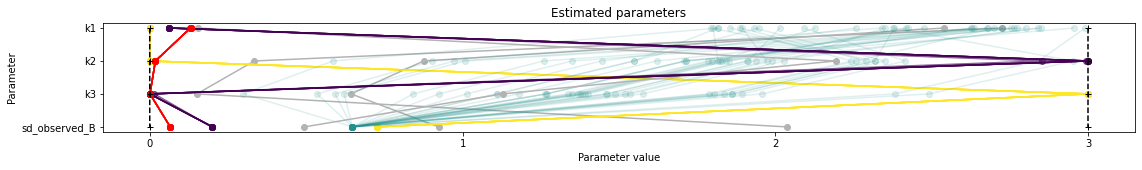

In [10]:
visualize.parameters(result)

In [11]:
startpoints = result.optimize_result.get_for_key('x0')
# print (startpoints)

In [66]:
results =   [['theta1', petab_problem.x_nominal[0], best_result[0], 0.2, 10**best_result[0]-1, obj(petab_problem.x_nominal), obj(best_result)],
             ['theta2', petab_problem.x_nominal[1], best_result[1], 0.1, 10**best_result[1]-1, obj(petab_problem.x_nominal), obj(best_result)],
             ['theta3', petab_problem.x_nominal[2], best_result[2], 0.0, 10**best_result[2]-1, obj(petab_problem.x_nominal), obj(best_result)],
             ['sigma', petab_problem.x_nominal[3], best_result[3], 0.15, 10**best_result[3]-1, obj(petab_problem.x_nominal), obj(best_result)]]

results_df = pd.DataFrame(results, columns=['Parameter', 'Nominal', 'best', 'nominal-linear', 'best-linear', 'nominal-likelihood', 'likelihood'])

print(results_df)

results_df.to_csv("estimation_results/"+param_scale+".csv", index=False)

  Parameter   Nominal      best  nominal-linear  best-linear  \
0    theta1  0.079181  0.111995            0.20     0.294182   
1    theta2  0.041393  0.024061            0.10     0.056966   
2    theta3  0.000000  0.000762            0.00     0.001757   
3     sigma  0.176091  0.038553            0.15     0.092832   

   nominal-likelihood  likelihood  
0             1.57531    -5.74813  
1             1.57531    -5.74813  
2             1.57531    -5.74813  
3             1.57531    -5.74813  
